In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from collections import Counter



In [ ]:
df = pd.read_csv(r"C:\Users\abhis\OneDrive\Desktop\week4\Sequence Modelling Basics\data\cleaned_sampled_train.csv")
df = df.dropna(subset=['cleaned_review'])
df = df[df['cleaned_review'].apply(lambda x: isinstance(x, str))]
df['polarity'] = df['polarity'].map({1: 0, 2: 1})
print("Unique polarity values:", df['polarity'].unique())
print("Polarity dtype:", df['polarity'].dtype)
print(df.head())
print(f"Dataset size: {len(df)}")


Unique polarity values: [0 1]
Polarity dtype: int64
                                      cleaned_review  \
0  the light bulb does not light anything, has a ...   
1  i purchased the flowtron bf 190 replacement bu...   
2  it doesn't work well in the hamilton beech sin...   
3  it took me forever to get through this book. i...   
4  this was a little of a deception, is smaller t...   

                      title  polarity  
0       PIAA SUPER LED BULB         0  
1               unsatisfied         0  
2  Refillable Coffee Filter         0  
3         Not to our liking         0  
4               Not so good         0  
Dataset size: 799998


In [ ]:
def simple_tokenizer(text):
    if isinstance(text, str):
        return text.lower().strip().split()
    return []


In [60]:
def simple_tokenizer(text):
    text = text.lower().strip()
    tokens = text.split()
    return tokens

df['tokens'] = df['cleaned_review'].apply(simple_tokenizer)

print(df['tokens'].head())


0    [the, light, bulb, does, not, light, anything,...
1    [i, purchased, the, flowtron, bf, 190, replace...
2    [it, doesn't, work, well, in, the, hamilton, b...
3    [it, took, me, forever, to, get, through, this...
4    [this, was, a, little, of, a, deception,, is, ...
Name: tokens, dtype: object


In [ ]:
from collections import Counter
all_tokens = [token for tokens in df['tokens'] for token in tokens]
token_counts = Counter(all_tokens)
vocab_size = 20000
most_common_tokens = token_counts.most_common(vocab_size - 2) 
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

word2idx = {PAD_TOKEN: 0, UNK_TOKEN: 1}
for i, (word, _) in enumerate(most_common_tokens, start=2):
    word2idx[word] = i

print(f"Vocabulary size (including PAD & UNK): {len(word2idx)}")

def tokens_to_indices(tokens):
    return [word2idx.get(token, word2idx[UNK_TOKEN]) for token in tokens]

df['indexed_tokens'] = df['tokens'].apply(tokens_to_indices)

print(df['indexed_tokens'].head())


Vocabulary size (including PAD & UNK): 20000
0    [2, 359, 3692, 107, 16, 359, 3498, 40, 5, 1024...
1    [4, 201, 2, 1, 1, 1, 717, 3692, 19, 210, 10101...
2    [10, 160, 130, 91, 11, 2, 6605, 1, 521, 2809, ...
3    [10, 297, 58, 1814, 6, 51, 146, 8, 131, 10, 10...
4    [8, 14, 5, 101, 7, 5, 1, 9, 1122, 64, 4, 1, 39...
Name: indexed_tokens, dtype: object


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 150

df['padded_tokens'] = list(pad_sequences(df['indexed_tokens'], maxlen=max_len, padding='post', truncating='post'))

print(df['padded_tokens'].head())
print(f"Padded sequences shape example: {df['padded_tokens'].iloc[0].shape}")


0    [2, 359, 3692, 107, 16, 359, 3498, 40, 5, 1024...
1    [4, 201, 2, 1, 1, 1, 717, 3692, 19, 210, 10101...
2    [10, 160, 130, 91, 11, 2, 6605, 1, 521, 2809, ...
3    [10, 297, 58, 1814, 6, 51, 146, 8, 131, 10, 10...
4    [8, 14, 5, 101, 7, 5, 1, 9, 1122, 64, 4, 1, 39...
Name: padded_tokens, dtype: object
Padded sequences shape example: (150,)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(np.array(texts), dtype=torch.long)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]


dataset = ReviewDataset(df['padded_tokens'].tolist(), df['polarity'])

batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

sample_batch = next(iter(dataloader))
print("Sample batch shapes:")
print("Texts:", sample_batch[0].shape)
print("Labels:", sample_batch[1].shape)


Sample batch shapes:
Texts: torch.Size([128, 150])
Labels: torch.Size([128])


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['polarity'])

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(np.array(texts), dtype=torch.long)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = ReviewDataset(train_df['padded_tokens'].tolist(), train_df['polarity'])
val_dataset = ReviewDataset(val_df['padded_tokens'].tolist(), val_df['polarity'])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

sample_batch = next(iter(train_loader))
print("Sample batch shape (X):", sample_batch[0].shape)
print("Sample batch shape (y):", sample_batch[1].shape)


Sample batch shape (X): torch.Size([128, 150])
Sample batch shape (y): torch.Size([128])


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(np.array(texts), dtype=torch.long)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = ReviewDataset(train_df['padded_tokens'].tolist(), train_df['polarity'])
val_dataset = ReviewDataset(val_df['padded_tokens'].tolist(), val_df['polarity'])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

sample_batch = next(iter(train_loader))
print("Sample batch shape (X):", sample_batch[0].shape)
print("Sample batch shape (y):", sample_batch[1].shape)


Sample batch shape (X): torch.Size([128, 150])
Sample batch shape (y): torch.Size([128])


In [ ]:
glove_path = r"C:\Users\abhis\OneDrive\Desktop\week4\Sequence Modelling Basics\glove.6B.200d.txt"

embedding_dim = 200
# now we will load the GloVe embeddings into a dictionary
print("Loading GloVe embeddings...")
glove_embeddings = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector
print(f"Loaded {len(glove_embeddings)} word vectors from GloVe.")

# Create embedding matrix
embedding_matrix = np.zeros((len(word2idx), embedding_dim))

for word, idx in word2idx.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        # Random vector for OOV words
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

print("Embedding matrix shape:", embedding_matrix.shape)


Loading GloVe embeddings...
Loaded 400000 word vectors from GloVe.
Embedding matrix shape: (20000, 200)


In [ ]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, dropout):
        super().__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # unfrozen embeddings
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout, bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        return self.sigmoid(self.fc(out)).squeeze(1)


In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [69]:
# Hyperparameters
hidden_dim = 256
num_layers = 1
dropout = 0.3
learning_rate = 1e-3

# Initialize model with pre-trained embeddings
model = LSTMClassifier(embedding_matrix, hidden_dim, num_layers, dropout).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)


C:\Users\abhis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [70]:
num_epochs = 10

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        preds = (outputs >= 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
        
    train_acc = correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(train_acc)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_outputs = model(x_val)
            loss = criterion(val_outputs, y_val)
            val_loss += loss.item()
            
            val_preds = (val_outputs >= 0.5).float()
            val_correct += (val_preds == y_val).sum().item()
            val_total += y_val.size(0)
            
    val_acc = val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10 - Train Loss: 0.4202, Train Acc: 0.7755 | Val Loss: 0.2584, Val Acc: 0.8929
Epoch 2/10 - Train Loss: 0.2338, Train Acc: 0.9057 | Val Loss: 0.2234, Val Acc: 0.9108
Epoch 3/10 - Train Loss: 0.1975, Train Acc: 0.9223 | Val Loss: 0.2090, Val Acc: 0.9182
Epoch 4/10 - Train Loss: 0.1711, Train Acc: 0.9344 | Val Loss: 0.2063, Val Acc: 0.9191
Epoch 5/10 - Train Loss: 0.1494, Train Acc: 0.9436 | Val Loss: 0.2255, Val Acc: 0.9162
Epoch 6/10 - Train Loss: 0.1298, Train Acc: 0.9519 | Val Loss: 0.2307, Val Acc: 0.9179
Epoch 7/10 - Train Loss: 0.1136, Train Acc: 0.9587 | Val Loss: 0.2493, Val Acc: 0.9140
Epoch 8/10 - Train Loss: 0.1019, Train Acc: 0.9635 | Val Loss: 0.2622, Val Acc: 0.9153
Epoch 9/10 - Train Loss: 0.0912, Train Acc: 0.9679 | Val Loss: 0.2513, Val Acc: 0.9136
Epoch 10/10 - Train Loss: 0.0835, Train Acc: 0.9710 | Val Loss: 0.2749, Val Acc: 0.9102


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import torch

def evaluate_model(model, dataloader, device, set_name="Set"):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)

            outputs = model(texts).squeeze()

            if torch.max(outputs) > 1 or torch.min(outputs) < 0:
                probs = torch.sigmoid(outputs)
            else:
                probs = outputs

            preds = (probs >= 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    pr_auc = average_precision_score(all_labels, all_probs)

    print(f"\nEvaluation on {set_name}:")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision      : {prec:.4f}")
    print(f"Recall         : {rec:.4f}")
    print(f"F1 Score       : {f1:.4f}")
    print(f"ROC AUC        : {roc_auc:.4f}")
    print(f"PR AUC         : {pr_auc:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {set_name}')
    plt.legend(loc='lower right')
    plt.grid(True)

    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {set_name}')
    plt.legend(loc='lower left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "confusion_matrix": cm
    }


# test


In [ ]:
df_test = pd.read_csv(r"C:\Users\abhis\OneDrive\Desktop\week4\Sequence Modelling Basics\data\cleaned_sampled_test.csv")

df_test['polarity'] = df_test['polarity'].map({1: 0, 2: 1})
print("Unique polarity values:", df_test['polarity'].unique())
print("Polarity dtype:", df_test['polarity'].dtype)
print(df_test.head())
print(f"Dataset size: {len(df_test)}")

Unique polarity values: [0 1]
Polarity dtype: int64
                                      cleaned_review  \
0  i did not receive the item number i ordered. t...   
1  good game. i got a lot of items, and i beat th...   
2  i did not receive the book in my kindle, i hav...   
3  i've had this grill for a year..but it stopped...   
4  benny hinn's approach to the topic is unbiblic...   

                           title  polarity  
0  Not the exact same item shown         0  
1                      beyplayer         0  
2                      the worst         0  
3             broke after a year         0  
4      Bad Theololgy at its best         0  
Dataset size: 385767


In [83]:
print("Class distribution in test set:")
print(df_test['polarity'].value_counts())

Class distribution in test set:
polarity
0    193368
1    192399
Name: count, dtype: int64


# we see that its not imbalanced


In [72]:
def simple_tokenizer(text):
    text = text.lower().strip()
    tokens = text.split()
    return tokens

df_test['tokens'] = df_test['cleaned_review'].apply(simple_tokenizer)

print(df_test['tokens'].head())


0    [i, did, not, receive, the, item, number, i, o...
1    [good, game., i, got, a, lot, of, items,, and,...
2    [i, did, not, receive, the, book, in, my, kind...
3    [i've, had, this, grill, for, a, year..but, it...
4    [benny, hinn's, approach, to, the, topic, is, ...
Name: tokens, dtype: object


In [73]:
import pickle
with open(r'C:\Users\abhis\OneDrive\Desktop\week4\Sequence Modelling Basics\word2idx.pkl', 'rb') as f:
    word2idx = pickle.load(f)


In [74]:
def tokens_to_indices(tokens):
    return [word2idx.get(token, word2idx["<UNK>"]) for token in tokens]

# Apply it to test set
df_test['indexed_tokens'] = df_test['tokens'].apply(tokens_to_indices)
print(df_test['indexed_tokens'].head())


0    [4, 104, 16, 1337, 2, 332, 630, 4, 4894, 8, 9,...
1    [41, 835, 4, 113, 5, 169, 7, 7687, 3, 4, 979, ...
2    [4, 104, 16, 1337, 2, 24, 11, 21, 12778, 4, 20...
3    [126, 43, 8, 2713, 12, 5, 1, 10, 704, 1926, 1,...
4    [16200, 1, 1598, 6, 2, 2321, 9, 1, 18878, 3, 1...
Name: indexed_tokens, dtype: object


In [75]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 150  # same as used in train

df_test['padded_tokens'] = list(pad_sequences(df_test['indexed_tokens'], maxlen=max_len, padding='post', truncating='post'))
print(df_test['padded_tokens'].head())


0    [4, 104, 16, 1337, 2, 332, 630, 4, 4894, 8, 9,...
1    [41, 835, 4, 113, 5, 169, 7, 7687, 3, 4, 979, ...
2    [4, 104, 16, 1337, 2, 24, 11, 21, 12778, 4, 20...
3    [126, 43, 8, 2713, 12, 5, 1, 10, 704, 1926, 1,...
4    [16200, 1, 1598, 6, 2, 2321, 9, 1, 18878, 3, 1...
Name: padded_tokens, dtype: object


In [76]:
import torch
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(np.array(texts), dtype=torch.long)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]


In [77]:
df_test['padded_tokens'] = list(pad_sequences(df_test['indexed_tokens'], maxlen=max_len, padding='post', truncating='post'))


In [78]:
# Create test dataset and dataloader
test_dataset = ReviewDataset(df_test['padded_tokens'].tolist(), df_test['polarity'])
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Sanity check
sample_test_batch = next(iter(test_loader))
print("Test batch shapes:", sample_test_batch[0].shape, sample_test_batch[1].shape)


Test batch shapes: torch.Size([128, 150]) torch.Size([128])



Evaluation on Test Set:
Accuracy       : 0.6029
Precision      : 0.6291
Recall         : 0.4965
F1 Score       : 0.5550
ROC AUC        : 0.6397
PR AUC         : 0.6360
Confusion Matrix:
[[137054  56314]
 [ 96873  95526]]


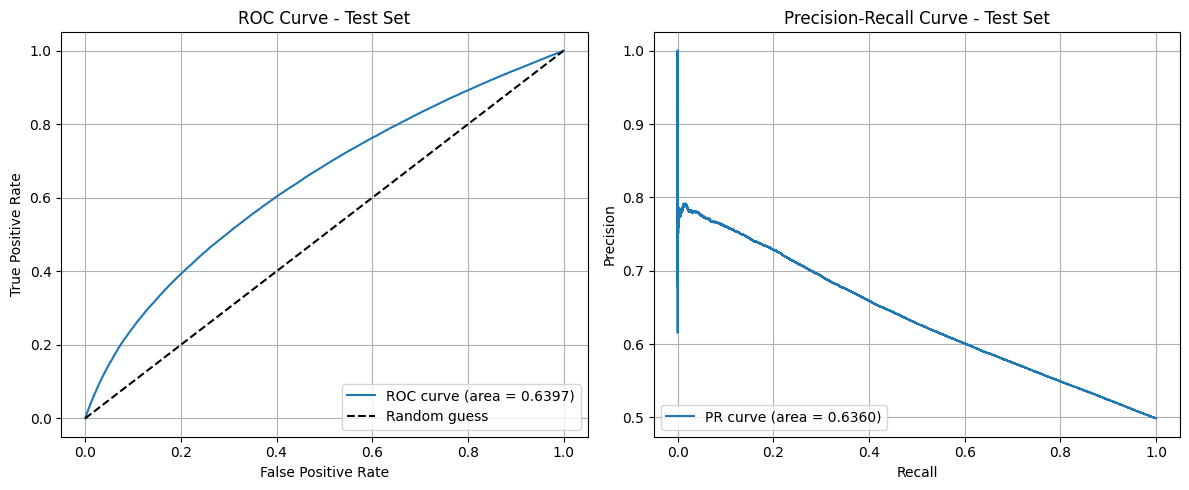


Classification Report on Test Set:
              precision    recall  f1-score   support

         0.0     0.5859    0.7088    0.6415    193368
         1.0     0.6291    0.4965    0.5550    192399

    accuracy                         0.6029    385767
   macro avg     0.6075    0.6026    0.5982    385767
weighted avg     0.6074    0.6029    0.5984    385767



In [ ]:
#evaluate on test set
test_metrics = evaluate_model(model, test_loader, device, set_name="Test Set")

# You can also optionally print a detailed classification report:
from sklearn.metrics import classification_report

all_labels = []
all_preds = []
model.eval()
with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts).squeeze()
        probs = torch.sigmoid(outputs) if (torch.max(outputs) > 1 or torch.min(outputs) < 0) else outputs
        preds = (probs >= 0.5).float()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("\nClassification Report on Test Set:")
print(classification_report(all_labels, all_preds, digits=4))


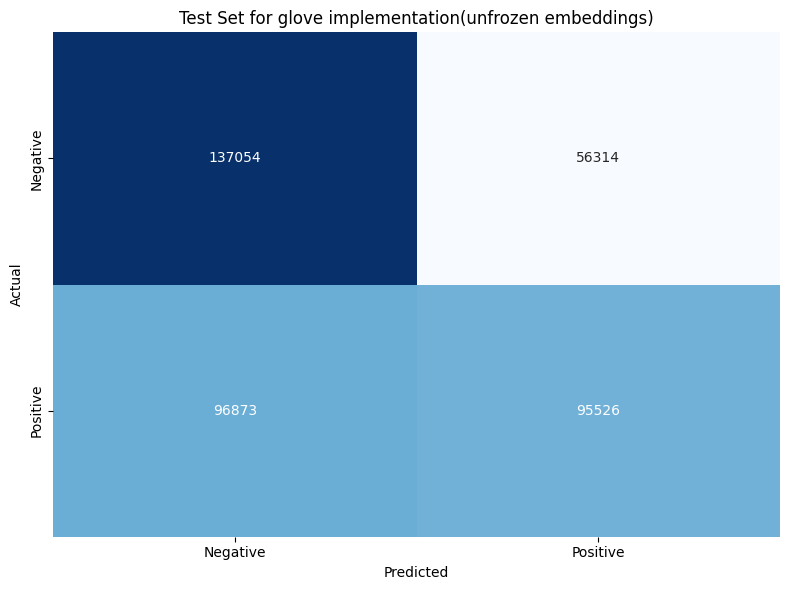

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = np.array([[137054 , 56314],
                [ 96873,  95526]]) #Had to plot confusion matrix this way as i did not want to re run the evaluation function just to get the confusion matrix :)

def plot_confusion_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)

# Create single plot
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(cm, "Test Set for glove implementation(unfrozen embeddings)", ax)
plt.tight_layout()
plt.show()